In [1]:
import itertools as it

import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree

from bt_kde import bt_kde

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

*Plot utils*

In [2]:
def _convert_sparse_df_to_grid(df):
    col = df.columns
    plot_df = df.pivot(*col)
    x, y = np.meshgrid(plot_df.index.values, plot_df.columns.values)
    z = plot_df.T.values
    return x, y, z

In [3]:
# For manipulating the plots
%matplotlib tk

In [4]:
%matplotlib inline
fig_size = [12, 9]
plt.rcParams["figure.figsize"] = fig_size

# Initialization

In [5]:
x_max, ndim = 100., 2
X = np.random.rand(15000, ndim) * x_max
X_t = np.random.rand(15000, ndim) * x_max

bw_list = [20.] * ndim

X[:5]

array([[  2.67933299e+01,   7.00699850e+01],
       [  8.91401921e+01,   2.92766757e+01],
       [  9.90768736e+01,   2.72484040e+01],
       [  5.31123360e-02,   6.18103448e+01],
       [  4.70351913e+01,   2.97638698e+01]])

# Compare results

In order to compare the probability provided by sklearn implementation and bt_kde<br>
We query a sample:

In [6]:
sk_model = BallTree(X)
sk_model.kernel_density(X_t[:10], bw_list[0])

array([ 1.00581779,  1.24980838,  0.65785115,  0.70747227,  1.29614828,
        0.77245092,  0.77217868,  1.409228  ,  0.78960695,  1.41099867])

In [7]:
bt_kde_eval = bt_kde(X, bw_list)
bt_kde_eval(X_t[:10])

array([ 1.00727214,  1.25173963,  0.65911904,  0.70862858,  1.29818038,
        0.77391294,  0.77385892,  1.41109765,  0.79052955,  1.41247053])

We have an approximation but we have the same results.

# Compare perf

## Init

In [8]:
%timeit -n1 -r1 BallTree(X)
%timeit -n1 -r1 bt_kde(X, bw_list)

1 loop, best of 1: 4.36 ms per loop
1 loop, best of 1: 584 ms per loop


Not realy conclusive perf wise on the initialization.<br>
The real benefit comes in the query.

## Query a few points

In [9]:
%timeit -n1 -r1 sk_model.kernel_density(X_t[:10], bw_list[0])
%timeit -n1 -r1 bt_kde_eval(X_t[:10])

1 loop, best of 1: 17.1 ms per loop
1 loop, best of 1: 5.48 ms per loop


We start to see the benefit of it.

## Query more points

In [10]:
%timeit -n1 -r1 sk_model.kernel_density(X_t, bw_list[0])
%timeit -n1 -r1 bt_kde_eval(X_t)

1 loop, best of 1: 21.9 s per loop
1 loop, best of 1: 752 ms per loop


Here we go!<br>
The implementation which is aggregating the distributions smash the perfs of classical KDE

# Accuracy study

We need to evaluate the approximation we are doing in order to understand the tradeoff we are dealing with.

## Tol parameter impact

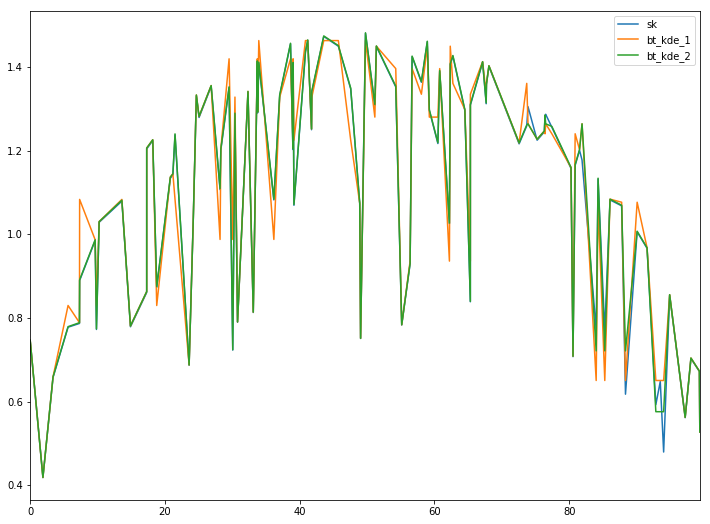

In [11]:
p_x = X_t[:100]

plot_df = pd.DataFrame(index=[x[0] for x in p_x])
plot_df['sk'] = BallTree(X).kernel_density(p_x, bw_list[0])
plot_df['bt_kde_1'] = bt_kde_eval(p_x, pred_tol=2.)
plot_df['bt_kde_2'] = bt_kde_eval(p_x, pred_tol=4.)

plot_df.sort_index(inplace=True)

plot_df.plot()
plt.show()

Here we can also note the impact of the tolerance parameter.

## Plot error

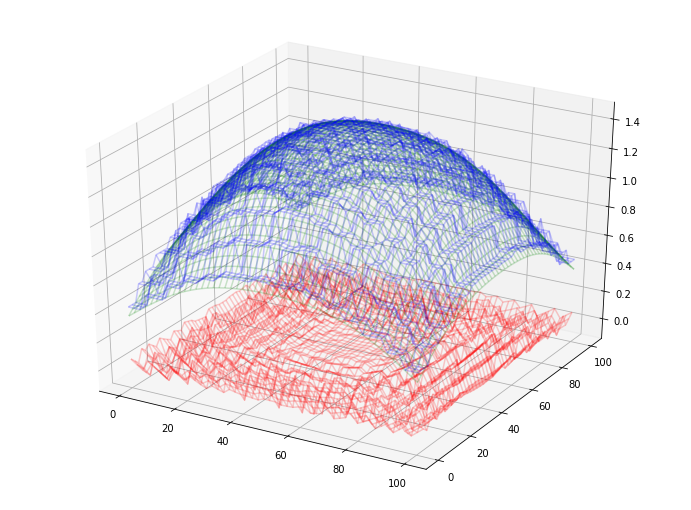

In [12]:
res = 50

plot_x = np.array([pt for pt in it.product(np.linspace(0., x_max, res), np.linspace(0., x_max, res))])

plot_df = pd.DataFrame(plot_x, columns=['x', 'y'])
plot_df['sk'] = BallTree(X).kernel_density(plot_x, bw_list[0])
plot_df['bt_kde'] = bt_kde_eval(plot_x)
plot_df['err'] = plot_df['bt_kde'] - plot_df['sk']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(*_convert_sparse_df_to_grid(plot_df[['x', 'y', 'sk']]), rstride=1, cstride=1,
                                                                          alpha=0.2, color='g', label='bt')

ax.plot_wireframe(*_convert_sparse_df_to_grid(plot_df[['x', 'y', 'bt_kde']]), rstride=1, cstride=1,
                                                                          alpha=0.2, color='b', label='sk')

ax.plot_wireframe(*_convert_sparse_df_to_grid(plot_df[['x', 'y', 'err']]), rstride=1, cstride=1,
                                                                            alpha=0.2, color='r', label='err')

plt.show()